In [ ]:
pip install tensorflow==2.13.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 26.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
      

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
from keras.models import load_model
import json

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Flatten, concatenate, Convolution2D, BatchNormalization, Activation


ModuleNotFoundError: No module named 'tensorflow.keras.layers.experimental'

# spilt data

## load data : 4 class

In [ ]:
SEED = 77
train_label_dir = "/content/drive/MyDrive/DR-Grading2/Dataset/EYEPACS/trainLabels.csv"
df_train = pd.read_csv(train_label_dir)
df_train

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


In [ ]:
df_train_4class = df_train.drop(df_train[df_train.level == 0].index)
df_train_4class

,image,level
4,15_left,1
5,15_right,2
6,16_left,4
7,16_right,4
9,17_right,1
...,...,...
35098,44323_left,1
35099,44323_right,1
35105,44328_right,1
35112,44337_left,1


In [ ]:
df_train_4class['level'] = df_train_4class['level'].astype(str)

In [ ]:
x = df_train_4class['image']
y = df_train_4class['level']
x, y = shuffle(x, y, random_state=SEED)
# Split into train, validation, and test sets
train_x, temp_x, train_y, temp_y = train_test_split(x, y, test_size=0.3,
                                                    stratify=y, random_state=SEED)
valid_x, test_x, valid_y, test_y = train_test_split(temp_x, temp_y, test_size=0.5,
                                                    stratify=temp_y, random_state=SEED)

In [ ]:
train = pd.concat([pd.Series(train_x, name='img'), pd.Series(train_y, name='level')], axis=1)
test = pd.concat([pd.Series(test_x, name='img'), pd.Series(test_y, name='level')], axis=1)
valid = pd.concat([pd.Series(valid_x, name='img'), pd.Series(valid_y, name='level')], axis=1)

## input 1 : circle crop (4 class DR)

In [ ]:
# Create new DataFrame with concatenated filenames
new_df = pd.DataFrame({
    'image':df_train_4class['image'] ,
    'abs_path': '/content/drive/MyDrive/DR-Grading2/Dataset/circle_crop2/train/' + df_train_4class['image'] + '_' + df_train_4class['level'].astype(str) + '.jpeg',
    'level': df_train_4class['level']

})

# Display the new DataFrame
new_df

,image,abs_path,level
4,15_left,/content/drive/MyDrive/DR-Grading2/Dataset/cir...,1
5,15_right,/content/drive/MyDrive/DR-Grading2/Dataset/cir...,2
6,16_left,/content/drive/MyDrive/DR-Grading2/Dataset/cir...,4
7,16_right,/content/drive/MyDrive/DR-Grading2/Dataset/cir...,4
9,17_right,/content/drive/MyDrive/DR-Grading2/Dataset/cir...,1
...,...,...,...
35098,44323_left,/content/drive/MyDrive/DR-Grading2/Dataset/cir...,1
35099,44323_right,/content/drive/MyDrive/DR-Grading2/Dataset/cir...,1
35105,44328_right,/content/drive/MyDrive/DR-Grading2/Dataset/cir...,1
35112,44337_left,/content/drive/MyDrive/DR-Grading2/Dataset/cir...,1


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Construct image paths
batch_size = 4

train_x['image'] = train['img'] + '_' + train['level'].astype(str) + '.jpeg'
valid_x['image'] = valid['img'] + '_' + valid['level'].astype(str) + '.jpeg'
test_x['image'] = test['img'] + '_' + test['level'].astype(str) + '.jpeg'

# Flow from dataframe for each data split
train_image_generator_CC = train_datagen.flow_from_dataframe(
    dataframe=new_df[new_df['image'].isin(train_x)],
    directory= None,
    x_col='abs_path',
    y_col='level',
    target_size=(256, 256),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    validate_filenames=False,
    seed=SEED)

valid_image_generator_CC = valid_datagen.flow_from_dataframe(
    dataframe=new_df[new_df['image'].isin(valid_x)],
     directory= None,
    x_col= 'abs_path',
    y_col='level',
    target_size=(256, 256),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    validate_filenames=False,
    seed=SEED)

test_image_generator_CC = test_datagen.flow_from_dataframe(
    dataframe=new_df[new_df['image'].isin(test_x)],
    directory= None,
    x_col='abs_path',
    y_col='level',
    target_size=(256, 256),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    validate_filenames=False,
    seed=SEED)

Found 6521 non-validated image filenames belonging to 4 classes.
Found 1397 non-validated image filenames belonging to 4 classes.
Found 1398 non-validated image filenames belonging to 4 classes.


## check

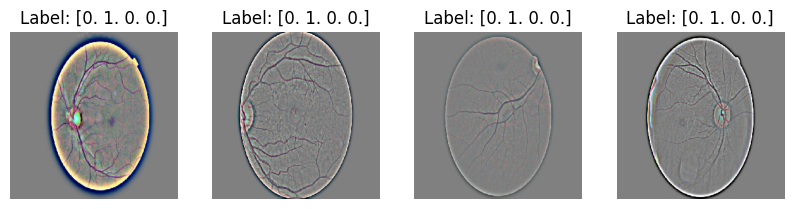

In [ ]:
import matplotlib.pyplot as plt

# Retrieve a batch of images and labels from the generator
images, labels = train_image_generator_CC[6]

# # Determine how many images to display
# num_images = images.shape[0]

# print(num_images)
# Set up the figure for plotting
plt.figure(figsize=(10, 10))

# Loop over each image in the batch and display it
for i in range(1, 5):
    plt.subplot(4, 4, i)  # Change 4, 4 to match the number of rows and columns you want
    plt.imshow(images[i - 1])  # Subtract 1 to account for zero-based indexing
    plt.title(f"Label: {labels[i - 1]}")  # Subtract 1 to account for zero-based indexing
    plt.axis('off')  # Turn off axis for better visualization

plt.show()


## input 2 : raw image (4 class DR)

In [ ]:
# Create new DataFrame with concatenated filenames
new_df_raw = pd.DataFrame({
    'image':df_train_4class['image'] ,
    'abs_path': '/content/drive/MyDrive/Dataset/EYEPACS/train/' + df_train_4class['image'] + '.jpeg',
    'level': df_train_4class['level']

})

# Display the new DataFrame
new_df_raw

,image,abs_path,level
4,15_left,/content/drive/MyDrive/Dataset/EYEPACS/train/1...,1
5,15_right,/content/drive/MyDrive/Dataset/EYEPACS/train/1...,2
6,16_left,/content/drive/MyDrive/Dataset/EYEPACS/train/1...,4
7,16_right,/content/drive/MyDrive/Dataset/EYEPACS/train/1...,4
9,17_right,/content/drive/MyDrive/Dataset/EYEPACS/train/1...,1
...,...,...,...
35098,44323_left,/content/drive/MyDrive/Dataset/EYEPACS/train/4...,1
35099,44323_right,/content/drive/MyDrive/Dataset/EYEPACS/train/4...,1
35105,44328_right,/content/drive/MyDrive/Dataset/EYEPACS/train/4...,1
35112,44337_left,/content/drive/MyDrive/Dataset/EYEPACS/train/4...,1


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Construct image paths
batch_size = 4

train_x['image'] = train['img'] + '_' + train['level'].astype(str) + '.jpeg'
valid_x['image'] = valid['img'] + '_' + valid['level'].astype(str) + '.jpeg'
test_x['image'] = test['img'] + '_' + test['level'].astype(str) + '.jpeg'

# Flow from dataframe for each data split
train_image_generator_raw = train_datagen.flow_from_dataframe(
    dataframe=new_df_raw[new_df_raw['image'].isin(train_x)],
    directory= None,
    x_col='abs_path',
    y_col='level',
    target_size=(256, 256),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    validate_filenames=False,
    seed=SEED)

valid_image_generator_raw = valid_datagen.flow_from_dataframe(
    dataframe=new_df_raw[new_df_raw['image'].isin(valid_x)],
     directory= None,
    x_col= 'abs_path',
    y_col='level',
    target_size=(256, 256),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    validate_filenames=False,
    seed=SEED)

test_image_generator_raw = test_datagen.flow_from_dataframe(
    dataframe=new_df_raw[new_df_raw['image'].isin(test_x)],
    directory= None,
    x_col='abs_path',
    y_col='level',
    target_size=(256, 256),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    validate_filenames=False,
    seed=SEED)

Found 6521 non-validated image filenames belonging to 4 classes.
Found 1397 non-validated image filenames belonging to 4 classes.
Found 1398 non-validated image filenames belonging to 4 classes.


## check

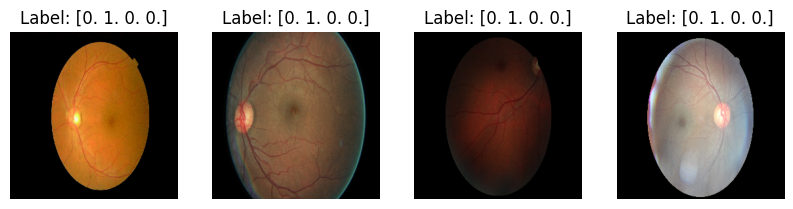

In [ ]:
import matplotlib.pyplot as plt

# # Retrieve a batch of images and labels from the generator
images, labels = train_image_generator_raw[6]

# # Determine how many images to display
num_images = images.shape[0]

# print(num_images)
# # Set up the figure for plotting
plt.figure(figsize=(10, 10))

# Loop over each image in the batch and display it
for i in range(1, 5):
    plt.subplot(4, 4, i)  # Change 4, 4 to match the number of rows and columns you want
    plt.imshow(images[i - 1])  # Subtract 1 to account for zero-based indexing
    plt.title(f"Label: {labels[i - 1]}")  # Subtract 1 to account for zero-based indexing
    plt.axis('off')  # Turn off axis for better visualization

plt.show()


# EfficientNetB7 Base Model New

In [ ]:
# Check generator output
# for data, labels in train_image_generator_CC:
#     print(data.shape, labels.shape)
#     break

In [ ]:
# Check zip function
for (data_cc, labels_cc), (data_raw, labels_raw) in zip(train_image_generator_CC, train_image_generator_raw):
    print(data_cc.shape, labels_cc.shape, data_raw.shape, labels_raw.shape)
    break

(4, 256, 256, 3) (4, 4) (4, 256, 256, 3) (4, 4)


In [ ]:
pretrained_model = EfficientNetB7(weights='imagenet', include_top=False,  input_shape=(256, 256, 3))

258076736/258076736 [==============================] - 7s 0us/step


In [ ]:
def combined_net():

    inp_cc = Input((256, 256, 3)) # the same input dim of pretrained_model
    inp_raw = Input((256, 256, 3)) # the same input dim of pretrained_model

    cc_output = pretrained_model(inp_cc)
    raw_output = pretrained_model(inp_raw)

    concat = concatenate([cc_output, raw_output], axis=-1)

    # top_activation = Activation('relu')(concat)
    # top_bn = BatchNormalization()(top_activation)
    global_avg_pool = GlobalAveragePooling2D()(top_bn)

      #  เพิ่ม Dense relu ได้

    main_output = Dense(4, activation='softmax', name='main_output')(global_avg_pool)
    # main_output = Dense(5, activation='softmax', name='main_output')(global_avg_pool)

    model = Model(inputs=[inp_cc, inp_raw], outputs=main_output)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

base_model = combined_net()
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 efficientnetb7 (Functional  (None, 8, 8, 2560)           6409768   ['input_2[0][0]',             
 )                                                        7          'input_3[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 8, 8, 5120)           0         ['efficientnetb7[0][0]',  

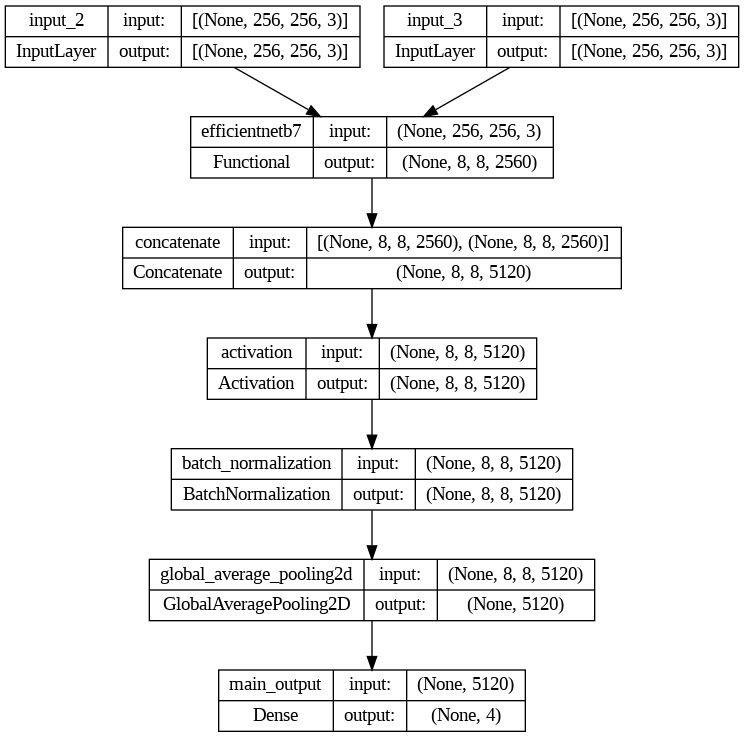

In [ ]:
keras.utils.plot_model(base_model, "/content/drive/MyDrive/DR-Grading2/graph-plot/multi_input_model_Eff_4class.png", show_shapes=True)

In [ ]:
def custom_data_generator(generator1, generator2):
    while True:
        batch_data1 = next(generator1)
        batch_data2 = next(generator2)
        yield [batch_data1[0], batch_data2[0]], batch_data1[1]  # Assuming both generators yield (data, labels) tuples

# Create custom data generators
train_data_generator = custom_data_generator(train_image_generator_CC, train_image_generator_raw)
valid_data_generator = custom_data_generator(valid_image_generator_CC, valid_image_generator_raw)
test_data_generator = custom_data_generator(test_image_generator_CC, test_image_generator_raw)

In [ ]:
# Early stopping callback to terminate training if validation loss doesn't improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,         # Stop training after 5 epochs with no improvement
    restore_best_weights=True  # Restore weights from the best epoch
)

Epoch 1/10
1631/1631 [==============================] - 9618s 6s/step - loss: 1.0528 - accuracy: 0.5510 - val_loss: 1.1894 - val_accuracy: 0.5684
Epoch 2/10
1631/1631 [==============================] - 1147s 703ms/step - loss: 0.9942 - accuracy: 0.5639 - val_loss: 1.2018 - val_accuracy: 0.5211
Epoch 3/10
1631/1631 [==============================] - 1115s 683ms/step - loss: 0.9630 - accuracy: 0.5729 - val_loss: 1.4884 - val_accuracy: 0.5648
Epoch 4/10
1631/1631 [==============================] - 1147s 703ms/step - loss: 0.9715 - accuracy: 0.5737 - val_loss: 3.5159 - val_accuracy: 0.2613
Epoch 5/10
1631/1631 [==============================] - 1142s 700ms/step - loss: 0.9288 - accuracy: 0.5884 - val_loss: 3.3426 - val_accuracy: 0.2634
Epoch 6/10
1631/1631 [==============================] - 1146s 702ms/step - loss: 0.9080 - accuracy: 0.5915 - val_loss: 3.5895 - val_accuracy: 0.2641


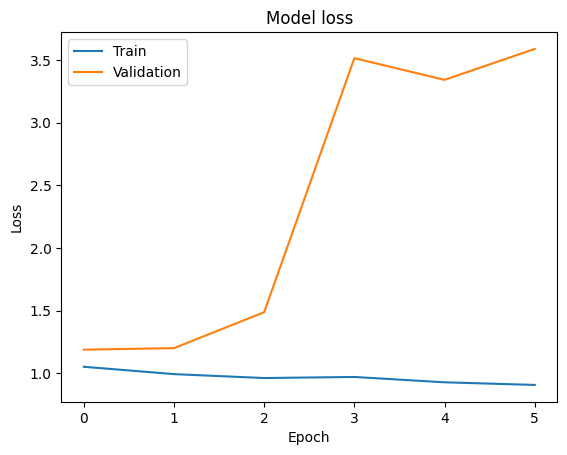

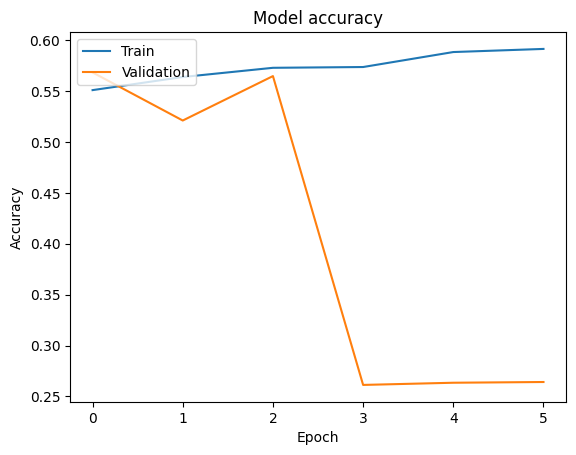

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

# Load the model
# model = load_model('/content/drive/MyDrive/DR-Grading2/model/eff_3_epochs.h5')

# epochs=3
epochs = 10
# Define a custom data generator to yield batches of data from multiple data generators


# Train the model using the custom data generators
history = base_model.fit(
    train_data_generator,
    validation_data=valid_data_generator,
    epochs=epochs,
    steps_per_epoch=len(train_image_generator_CC),
    validation_steps=len(valid_image_generator_CC),
    shuffle=True,
    callbacks=[early_stopping]
)

# Save the history to a variable
training_history = history.history

# Save the history to a JSON file
with open('/content/drive/MyDrive/DR-Grading2/graph-plot/training_history_4class_EffB7_10epoch.json', 'w') as json_file:
    json.dump(training_history, json_file)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/content/drive/MyDrive/DR-Grading2/graph-plot/loss_plot_4class_EffB7_10epoch.png')  # Save the plot as loss_plot.png
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/content/drive/MyDrive/DR-Grading2/graph-plot/accuracy_plot_4class_EffB7_10epoch.png')  # Save the plot as accuracy_plot.png
plt.show()

base_model.save('/content/drive/MyDrive/DR-Grading2/model/eff_4class_10epochs.h5')

In [ ]:
import keras
import tensorflow
print(keras.__version__)
print(tensorflow.__version__)

2.13.1
2.13.1


In [ ]:
loaded_model = load_model('/content/drive/MyDrive/DR-Grading2/model/eff_4class_3epochs.h5')
evaluation = loaded_model.evaluate(test_data_generator, steps=len(test_image_generator_CC))

# Print the evaluation results
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

350/350 [==============================] - 1792s 5s/step - loss: 1.2325 - accuracy: 0.5680
Loss: 1.2325422763824463
Accuracy: 0.5679542422294617


In [ ]:
# Make predictions on the test data
predictions = loaded_model.predict(test_data_generator, steps=len(test_image_generator_CC))

# Extract predicted labels (assuming predictions are probabilities)
predicted_labels = np.argmax(predictions, axis=1)

350/350 [==============================] - 1742s 5s/step


In [ ]:
# Choose a filename and path within your Google Drive
filename = 'eff_4class_3epochs_test2_predict.npy'  # Replace with your desired filename (e.g., 'my_predictions.txt')
path = '/content/drive/MyDrive/DR-Grading2/predictions/'  # Replace with the desired path within your Drive

# Save the array (preserving its structure)
np.save(path + filename, predictions)

# Save the labels (as integers)
np.savetxt(path + 'eff_4class_3epochs_test2_predict.txt', predicted_labels, fmt='%d')  # Save as integers

print(f'Predictions saved to: {path + filename}')
print(f'Predicted labels saved to: {path + "eff_4class_3epochs_test2_predict.txt"}')

Predictions saved to: /content/drive/MyDrive/DR-Grading2/predictions/eff_4class_3epochs_test2_predict.npy
Predicted labels saved to: /content/drive/MyDrive/DR-Grading2/predictions/eff_4class_3epochs_test2_predict.txt


In [ ]:
#  train ต่อจากที่เซฟ

# from tensorflow.keras.models import load_model

# # Load the saved model
# loaded_model = load_model('/content/drive/MyDrive/DR-Grading2/model/eff_3_epochs.h5')

# # Train the model using the custom data generators for additional epochs (epochs 4-10)
# additional_epochs = 7

# additional_history = loaded_model.fit(
#     train_data_generator,
#     validation_data=valid_data_generator,
#     epochs=additional_epochs,
#     steps_per_epoch=len(train_image_generator_CC),
#     validation_steps=len(valid_image_generator_CC),
#     shuffle=True
# )

# # Save the history of additional training to a variable
# additional_training_history = additional_history.history

# # Append the additional training history to the existing training history
# for key in additional_training_history.keys():
#     training_history[key].extend(additional_training_history[key])

# # Save the combined training history to a JSON file
# with open('/content/drive/MyDrive/DR-Grading2/graph-plot/training_history_combined.json', 'w') as json_file:
#     json.dump(training_history, json_file)

# # Plot training & validation loss values for combined training
# plt.plot(training_history['loss'])
# plt.plot(training_history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.savefig('/content/drive/MyDrive/DR-Grading2/graph-plot/loss_plot_combined.png')  # Save the plot as loss_plot_combined.png
# plt.show()

# # Plot training & validation accuracy values for combined training
# plt.plot(training_history['accuracy'])
# plt.plot(training_history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.savefig('/content/drive/MyDrive/DR-Grading2/graph-plot/accuracy_plot_combined.png')  # Save the plot as accuracy_plot_combined.png
# plt.show()

# # Save the model after additional training
# loaded_model.save('/content/drive/MyDrive/DR-Grading2/model/eff_10_epochs.h5')


Epoch 1/7
  79/6147 [..............................] - ETA: 11:17:36 - loss: 0.6876 - accuracy: 0.7975

KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get predictions from the model
y_pred_prob = base_model.predict(test_data_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels from the generator
y_true = test_image_generator_CC.classes

# Generate classification report
report = classification_report(y_true, y_pred)
print(report)

# InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3

In [ ]:
inc_model =  InceptionV3(weights='imagenet', include_top=False,  input_shape=(256, 256, 3))

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
def combined_net():

    inp_cc = Input((256, 256, 3)) # the same input dim of pretrained_model
    inp_raw = Input((256, 256, 3)) # the same input dim of pretrained_model

    cc_output = inc_model(inp_cc)
    raw_output = inc_model(inp_raw)

    concat = concatenate([cc_output, raw_output], axis=-1)

    top_activation = Activation('relu')(concat)
    top_bn = BatchNormalization()(top_activation)
    global_avg_pool = GlobalAveragePooling2D()(top_bn)

    main_output = Dense(4, activation='softmax', name='main_output')(global_avg_pool)
    # main_output = Dense(5, activation='softmax', name='main_output')(global_avg_pool)


    model = Model(inputs=[inp_cc, inp_raw], outputs=main_output)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

base_model = combined_net()
base_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 inception_v3 (Functional)   (None, 6, 6, 2048)           2180278   ['input_6[0][0]',             
                                                          4          'input_7[0][0]']             
                                                                                                  
 concatenate_4 (Concatenate  (None, 6, 6, 4096)           0         ['inception_v3[4][0]',  

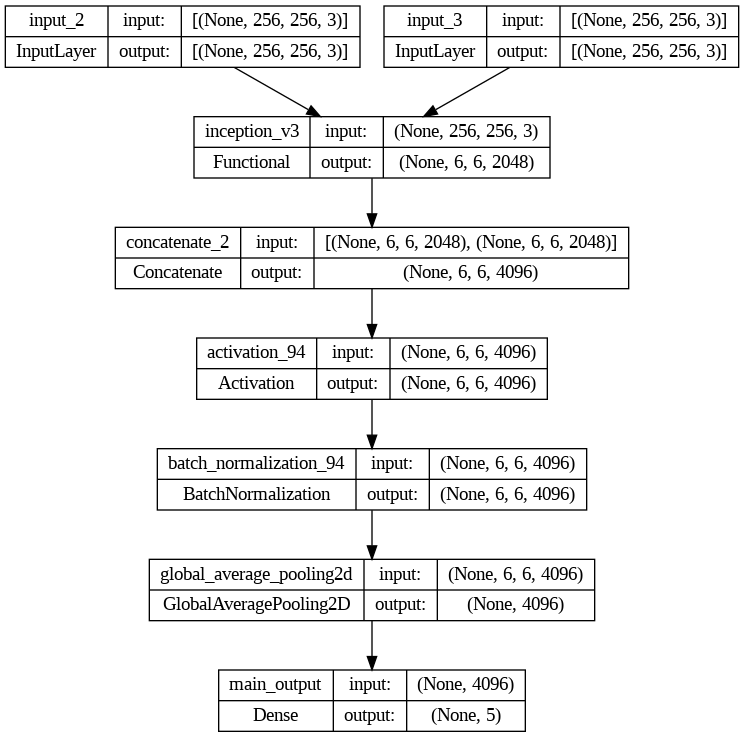

In [ ]:
keras.utils.plot_model(base_model, "/content/drive/MyDrive/DR-Grading2/graph-plot/multi_input_model_inceptionv3.png", show_shapes=True)

In [ ]:
def custom_data_generator(generator1, generator2):
    while True:
        batch_data1 = next(generator1)
        batch_data2 = next(generator2)
        yield [batch_data1[0], batch_data2[0]], batch_data1[1]  # Assuming both generators yield (data, labels) tuples

# Create custom data generators
train_data_generator = custom_data_generator(train_image_generator_CC, train_image_generator_raw)
valid_data_generator = custom_data_generator(valid_image_generator_CC, valid_image_generator_raw)
test_data_generator = custom_data_generator(test_image_generator_CC, test_image_generator_raw)

Epoch 1/3
6147/6147 [==============================] - 32588s 5s/step - loss: 0.8630 - accuracy: 0.7318 - val_loss: 0.9893 - val_accuracy: 0.7242
Epoch 2/3
6147/6147 [==============================] - 1906s 310ms/step - loss: 0.8012 - accuracy: 0.7391 - val_loss: 0.8873 - val_accuracy: 0.7381
Epoch 3/3
6147/6147 [==============================] - 1919s 312ms/step - loss: 0.7797 - accuracy: 0.7444 - val_loss: 1.6486 - val_accuracy: 0.7349


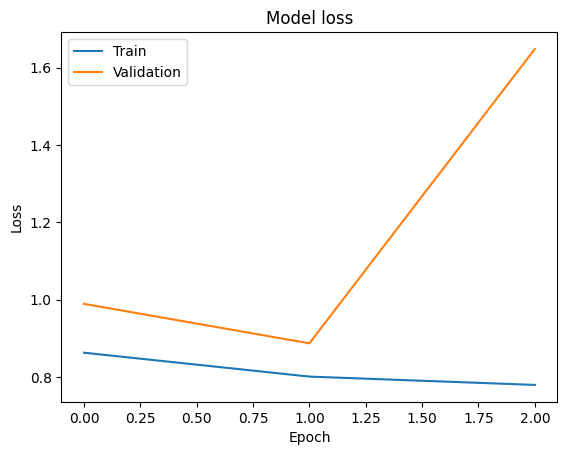

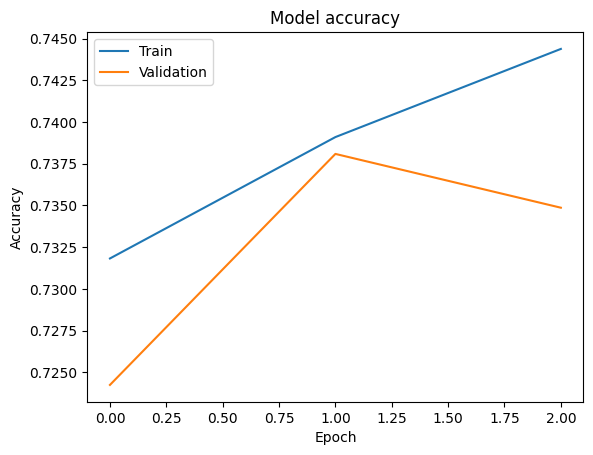

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

# Load the model
# model = load_model('/content/drive/MyDrive/DR-Grading2/model/eff_3_epochs.h5')

epochs=3
# Define a custom data generator to yield batches of data from multiple data generators

# Train the model using the custom data generators
history = base_model.fit(
    train_data_generator,
    validation_data=valid_data_generator,
    epochs=epochs,
    steps_per_epoch=len(train_image_generator_CC),
    validation_steps=len(valid_image_generator_CC),
    shuffle=True
)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/content/drive/MyDrive/DR-Grading2/graph-plot/loss_plot_4class_3epoch_incepV3.png')  # Save the plot as loss_plot.png
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/content/drive/MyDrive/DR-Grading2/graph-plot/accuracy_plot_4class_3epoch_incepV3.png')  # Save the plot as accuracy_plot.png
plt.show()

# Save the model architecture and weights
model_save_path = '/content/drive/MyDrive/DR-Grading2/models/model_4class_3epoch_incepV3.h5'
base_model.save(model_save_path)

# Save the optimizer state
optimizer_save_path = '/content/drive/MyDrive/DR-Grading2/models/optimizer_4class_3epoch_incepV3.pkl'
import pickle
with open(optimizer_save_path, 'wb') as f:
    pickle.dump(base_model.optimizer.get_config(), f)

# Save the training history to a variable
training_history = history.history

# Save the training history to a JSON file
history_save_path = '/content/drive/MyDrive/DR-Grading2/graph-plot/training_history_4class_3epoch_incepV3.json'
with open(history_save_path, 'w') as json_file:
    json.dump(training_history, json_file)

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/DR-Grading2/models/model_3epoch_incepV3.h5')
evaluation = loaded_model.evaluate(test_data_generator, steps=len(test_image_generator_CC))

# Print the evaluation results
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

1318/1318 [==============================] - 6048s 5s/step - loss: 1.6540 - accuracy: 0.7360
Loss: 1.6539510488510132
Accuracy: 0.736003041267395


In [ ]:
loaded_model = load_model('/content/drive/MyDrive/DR-Grading2/models/model_3epoch_incepV3.h5')
import numpy as np
from sklearn.metrics import classification_report

# Get predictions from the model
y_pred_prob = loaded_model.predict(test_data_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels from the generator
y_true = test_image_generator_CC.classes

# Generate classification report
report = classification_report(y_true, y_pred)
print(report)


     17/Unknown - 118s 7s/step

KeyboardInterrupt: 

# confusion matrix

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Load the saved model (assuming it's a Keras model)
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

### predict

In [ ]:
# Check zip function
for (data_cc, labels_cc), (data_raw, labels_raw) in zip(train_image_generator_CC, train_image_generator_raw):
    print(data_cc.shape, labels_cc.shape, data_raw.shape, labels_raw.shape)
    break

(4, 256, 256, 3) (4, 4) (4, 256, 256, 3) (4, 4)


In [ ]:
def custom_data_generator(generator1, generator2):
    while True:
        batch_data1 = next(generator1)
        batch_data2 = next(generator2)
        yield [batch_data1[0], batch_data2[0]], batch_data1[1]  # both generators yield (data, labels) tuples

# Create custom data generators
train_data_generator = custom_data_generator(train_image_generator_CC, train_image_generator_raw)
valid_data_generator = custom_data_generator(valid_image_generator_CC, valid_image_generator_raw)
test_data_generator = custom_data_generator(test_image_generator_CC, test_image_generator_raw)

In [ ]:
model = load_model('/content/drive/MyDrive/DR-Grading2/model/eff_4class_3epochs.h5')

# Make predictions on the test data
predictions = model.predict(test_data_generator, steps=len(test_image_generator_CC))

# Extract predicted labels (assuming predictions are probabilities)
predicted_labels = np.argmax(predictions, axis=1)

350/350 [==============================] - 2568s 7s/step


In [ ]:
predicted_labels.shape

(1398,)

### save file

In [ ]:
# Choose a filename and path within your Google Drive
filename = 'eff_4class_3epochs_predict.npy'  # Replace with your desired filename (e.g., 'my_predictions.txt')
path = '/content/drive/MyDrive/DR-Grading2/'  # Replace with the desired path within your Drive

# Save the array (preserving its structure)
np.save(path + filename, predictions)

# Save the labels (as integers)
np.savetxt(path + 'eff_4class_3epochs_predict.txt', predicted_labels, fmt='%d')  # Save as integers

print(f'Predictions saved to: {path + filename}')
print(f'Predicted labels saved to: {path + "eff_4class_3epochs_predict.txt"}')

Predictions saved to: /content/drive/MyDrive/DR-Grading2/eff_4class_3epochs_predict.npy
Predicted labels saved to: /content/drive/MyDrive/DR-Grading2/eff_4class_3epochs_predict.txt


### create confusion

In [ ]:
# Choose a filename and path within your Google Drive
filename = 'eff_4class_3epochs_test2_predict.npy'  # Replace with your desired filename (e.g., 'my_predictions.txt')
path = '/content/drive/MyDrive/DR-Grading2/predictions/'  # Replace with the desired path within your Drive
predictions = np.load(path + filename)
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels.shape

(1398,)

In [ ]:
predictions

array([[0.10913313, 0.53437686, 0.22095251, 0.13553755],
       [0.10445528, 0.52719605, 0.22657038, 0.14177816],
       [0.10458016, 0.52726525, 0.22661483, 0.1415398 ],
       ...,
       [0.10722546, 0.5314314 , 0.22345448, 0.13788867],
       [0.10857603, 0.5320606 , 0.22206174, 0.13730165],
       [0.11121546, 0.5388601 , 0.217722  , 0.13220252]], dtype=float32)

In [ ]:
class_mapping = {
    0: 1,
    1: 2,
    2: 3,
    3: 4
}

In [ ]:
predicted_labels_str = [class_mapping[label] for label in predicted_labels]
print(predicted_labels_str)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [ ]:
predicted_labels_np = np.array(predicted_labels_str)

In [ ]:
def custom_data_generator(generator1, generator2):
    while True:
        batch_data1 = next(generator1)
        batch_data2 = next(generator2)
        yield [batch_data1[0], batch_data2[0]], batch_data1[1]  # Assuming both generators yield (data, labels) tuples

# Create custom data generators
train_data_generator = custom_data_generator(train_image_generator_CC, train_image_generator_raw)
valid_data_generator = custom_data_generator(valid_image_generator_CC, valid_image_generator_raw)
test_data_generator = custom_data_generator(test_image_generator_CC, test_image_generator_raw)

In [ ]:
test['level'] = test['level'].astype(int)
truth_labels = test['level'].to_numpy()
truth_labels

array([3, 4, 2, ..., 2, 2, 1])

In [ ]:
dataframe = new_df[new_df['image'].isin(test_x)]
dataframe['level'] = dataframe['level'].astype(int)
truth_labels = dataframe['level'].to_numpy()

<ipython-input-33-75d6949ce749>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['level'] = dataframe['level'].astype(int)


In [ ]:
dataframe['level'].value_counts()

,count
level,
2,794
1,367
3,131
4,106


In [ ]:
predict = pd.DataFrame(predicted_labels_str, columns=['predict'])
predict['predict'].value_counts()

,count
predict,
2,1398


In [ ]:
print(truth_labels.shape ,predicted_labels_np.shape)
print(type(truth_labels), type(predicted_labels))

(1398,) (1398,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
predicted_labels_np

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
predicted_labels_np = np.array(predicted_labels_str)

,predict
0,2
1,2
2,2
3,2
4,2
...,...
1393,2
1394,2
1395,2
1396,2


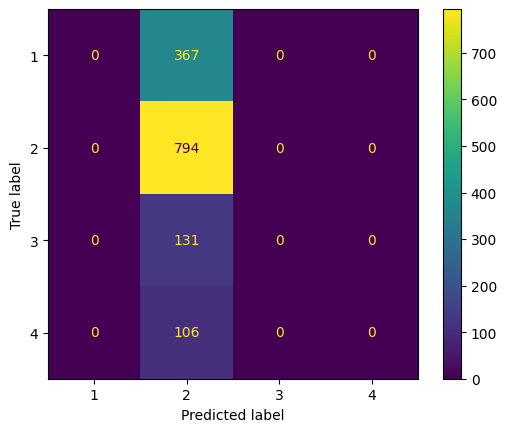

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming you have truth_labels and predicted_labels as NumPy arrays

# Calculate the confusion matrix
confusion_matrix = confusion_matrix(truth_labels, predicted_labels_np)

# Import metrics for ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

# Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[1, 2, 3, 4])

# Plot the confusion matrix
cm_display.plot()
plt.savefig('/content/drive/MyDrive/DR-Grading2/metrix/eff_4class_3epochs_test2.png')
# Display the plot
plt.show()